In [1]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import numpy as np
from matplotlib_venn import venn2
from matplotlib_venn import venn3

## Read data

In [10]:
bw = pd.read_csv('../step1_Reads_quality_comparison_FASTQ/results/Sequence_Duplication_Levels_warn_bgi.txt')
iw = pd.read_csv('../step1_Reads_quality_comparison_FASTQ/results/Sequence_Duplication_Levels_warn_ill.txt')
bfl = pd.read_csv('../step1_Reads_quality_comparison_FASTQ/results/Sequence_Duplication_Levels_fail_bgi.txt')
ifl = pd.read_csv('../step1_Reads_quality_comparison_FASTQ/results/Sequence_Duplication_Levels_fail_ill.txt')

bad = pd.read_csv('../step3_motus/input/samples_Bad.csv', header=None)
bad.columns = ['Sample']
wrs = pd.read_csv('../step3_motus/input/samples_Wrs.csv', header=None)
wrs.columns = ['Sample']

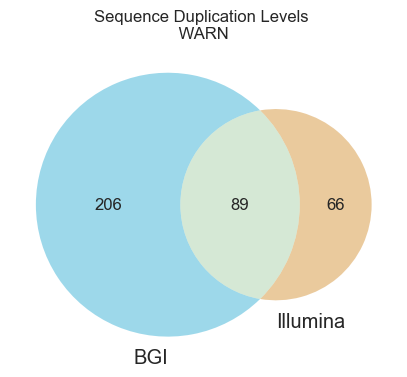

In [57]:
# venn diagram
plt.figure(figsize=(5,5))
venn2([set(bw['Filename']), set(iw['Filename'])], set_labels = ('BGI', 'Illumina'), set_colors=('#0c9fcc','#cc7c0c'))
plt.title('Sequence Duplication Levels \n WARN ')
plt.savefig('results/Sequence_Duplication_Levels_warn1.png')

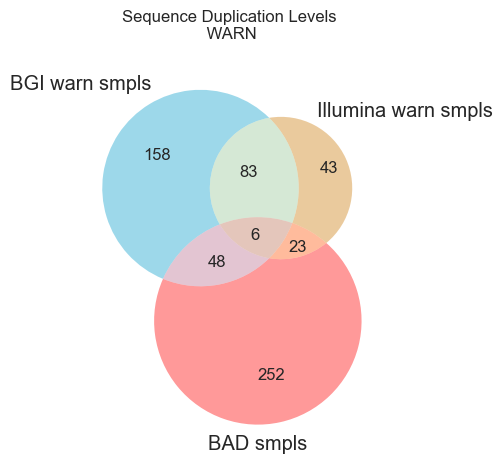

In [58]:
# 3 set venn diagram
plt.figure(figsize=(5,5))
venn3([set(bw['Filename']), set(iw['Filename']), set(bad['Sample'])], set_labels = ('BGI warn smpls', 'Illumina warn smpls', 'BAD smpls'), set_colors=('#0c9fcc','#cc7c0c', 'red'))
plt.title('Sequence Duplication Levels \n WARN \n ')
plt.savefig('results/Sequence_Duplication_Levels_warn2.png')

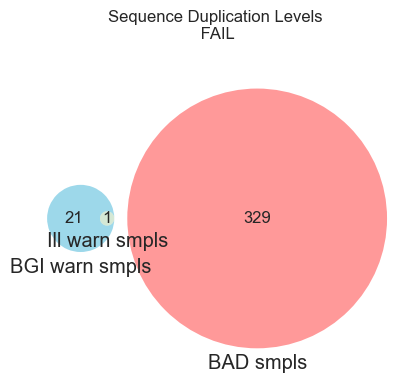

In [59]:
# 3 set venn diagram
plt.figure(figsize=(5,5))
venn3([set(bfl['Filename']), set(ifl['Filename']), set(bad['Sample'])], set_labels = ('BGI warn smpls', 'Ill warn smpls', 'BAD smpls'), set_colors=( '#0c9fcc','#cc7c0c', 'red'))
plt.title('Sequence Duplication Levels \n FAIL \n ')
plt.savefig('results/Sequence_Duplication_Levels_fail1.png')

In [31]:
ovr = pd.read_excel('results/Kraken2_overlaping_sp.xlsx')
bch = pd.read_excel('input/BGI_samplesheet_27-10-2020-Elinile.xlsx')
mrg = ovr.merge(bch, left_on='sample_name', right_on='SampleID', how='inner')
ibc = pd.read_excel('input/Metagenome_Illumina_data.xlsx')
mrg = mrg.merge(ibc, left_on='sample_name', right_on='Sample_Name', how='inner', suffixes=('_bgi', '_ill'))
mrg.head(2)

/Users/katerynapantiukh/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,sample_name,bgi_uniq_perc,shared_perc,ill_uniq_perc,bgi_uniq_numb,shared_numb,ill_uniq_numb,SampleID,Plate_bgi,Pos_bgi,...,Qubit Concentration(ng/ul),Volume(ul),Total amount(ug),Sample QC Results,Sample QC Memo,Nucleic acid hole,Suggestion,Status,duplicates,MMPH/BGI set (yes/no/maybe)
0,VJEFJG,34.667373,55.817652,9.514975,1308,2106,359,VJEFJG,MBbgi-01,H8,...,10.300,38.7795,0.39943,Pass,None,NaN,Library preparation,waiting for feedback,NaN,yes
1,VH3A20,20.791797,55.254913,23.953290,730,1940,841,VH3A20,MBbgi-25,A11,...,105.711,17.4036,1.83975,Pass,None,F03,Go ahead,Waiting for feedback,NaN,yes


In [36]:
bw.columns = ['sample_name']
bw['status'] = 'bgi-warn'
iw.columns = ['sample_name']
iw['status'] = 'ill-warn'

# combine the data
wrn = pd.concat([bw, iw], axis=0)
wrn.head(2)

,sample_name,status
0,VZIO94,bgi-warn
1,VP8AMJ,bgi-warn


In [47]:
mrg = mrg.merge(wrn, on='sample_name', how='left')
# fill na in staus column with 'ill-ill'
mrg['status'] = mrg['status'].fillna('no_wrn')
mrg.head(2)

,sample_name,bgi_uniq_perc,shared_perc,ill_uniq_perc,bgi_uniq_numb,shared_numb,ill_uniq_numb,SampleID,Plate_bgi,Pos_bgi,...,Sample QC Results,Sample QC Memo,Nucleic acid hole,Suggestion,Status,duplicates,MMPH/BGI set (yes/no/maybe),status_x,status_y,status
0,VOE87W,5.869324,90.531561,3.599114,212,3270,130,VOE87W,MBbgi-01,H9,...,Pass,None,C03,Go ahead,Sequencing,NaN,yes,no_wrn,NaN,no_wrn
1,VC9XZ6,8.964781,87.015297,4.019922,252,2446,113,VC9XZ6,MBbgi-01,G2,...,Pass,None,G08,Go ahead,Sequencing,NaN,yes,no_wrn,NaN,no_wrn


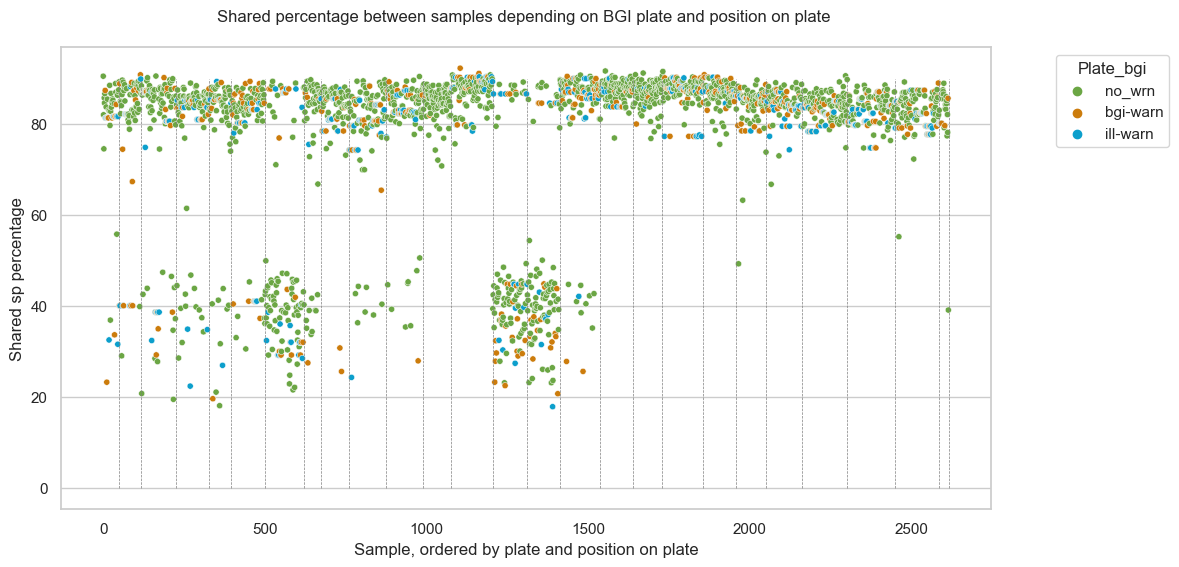

In [55]:
mrg = mrg.sort_values(by='Pos_bgi').reset_index(drop=True)
mrg = mrg.sort_values(by='Plate_bgi').reset_index(drop=True)
plate_counts = mrg['Plate_bgi'].value_counts(sort=False)
plate_counts = plate_counts.to_frame().reset_index()
plate_counts['cumulative'] = plate_counts['Plate_bgi'].cumsum()

clr = ['#6ba644', '#cc7c0c', '#0c9fcc']

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.scatterplot(data=mrg, x=mrg.index, y="shared_perc", hue="status", palette=clr, s=20)
plt.ylabel('Shared sp percentage')
plt.xlabel('Sample, ordered by plate and position on plate')
#plt.xticks('')
plt.title('Shared percentage between samples depending on BGI plate and position on plate \n')
# 2 columns legend
plt.legend(title='Plate_bgi', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(axis='x')
plt.vlines(plate_counts['cumulative'], 0, 90, colors='grey', linestyles='dashed', linewidth=0.5)

plt.savefig('results/warn_plate.png', dpi=300, bbox_inches='tight')

## motus check

In [5]:
mB = pd.read_csv('input/samples_Bad_sub100.csv', header=None)
mB.columns = ['sample_name']
mB['status'] = 'bad'
mB.head(2)

,sample_name,status
0,VJEFJG,bad
1,VH3A20,bad


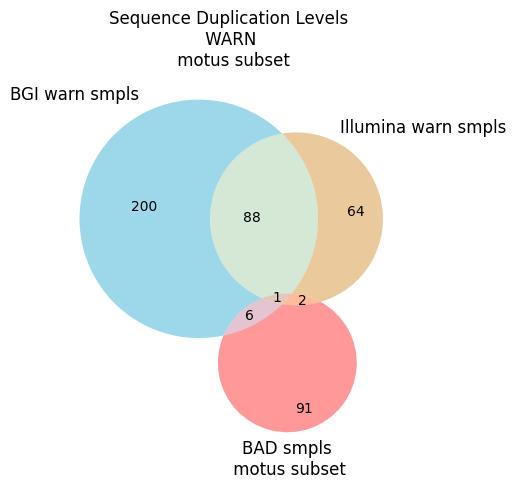

In [6]:
# venn diagram
plt.figure(figsize=(5,5))
venn3([set(bw['Filename']), set(iw['Filename']), set(mB['sample_name'])], set_labels = ('BGI warn smpls', 'Illumina warn smpls', 'BAD smpls\n motus subset'), set_colors=('#0c9fcc','#cc7c0c', 'red'))
plt.title('Sequence Duplication Levels \n WARN \n motus subset')
plt.savefig('results/Sequence_Duplication_Levels_warn3.png')

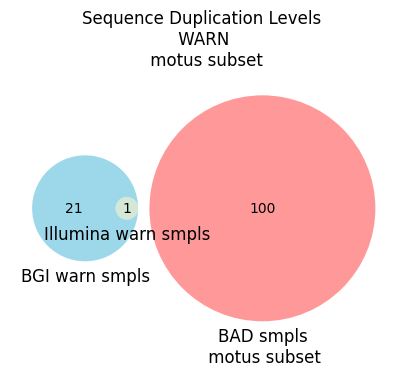

In [7]:
plt.figure(figsize=(5,5))
venn3([set(bfl['Filename']), set(ifl['Filename']), set(mB['sample_name'])], set_labels = ('BGI warn smpls', 'Illumina warn smpls', 'BAD smpls\n motus subset'), set_colors=('#0c9fcc','#cc7c0c', 'red'))
plt.title('Sequence Duplication Levels \n WARN \n motus subset')
plt.savefig('results/Sequence_Duplication_Levels_warn4.png')

In [9]:
wrn = set(bw['Filename']).union(set(iw['Filename']))
# find overlapping samples
wrn.intersection(set(mB['sample_name']))


{'V0L9VT',
 'VAQ2EH',
 'VF1M6Y',
 'VG2PS6',
 'VHKBE9',
 'VLP13D',
 'VY824V',
 'VYHVL7',
 'VZIO94'}

In [11]:
fl = set(bfl['Filename']).union(set(ifl['Filename']))
# find overlapping samples
fl.intersection(set(mB['sample_name']))

set()

In [20]:
wrn = set(bw['Filename']).union(set(iw['Filename']))
# Find bad samples that do not overlap with wrn samples
bad_samples_not_wrn = set(bad['Sample']).difference(wrn)
len(bad_samples_not_wrn)
# Find bad, no wrn samples not overlapping with mB samples
bad_samples_not_wrn_not_mB = bad_samples_not_wrn.difference(set(mB['sample_name']))

# Convert to DataFrame and save to CSV
pd.DataFrame(list(bad_samples_not_wrn_not_mB), columns=['Sample']).to_csv('results/bad_no_wrn_no_mB.csv', index=False)
